In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
# %load_ext tensorboard

In [6]:
!python --version

Python 3.10.11


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip "drive/MyDrive/archive (7).zip"

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
DATA_PATH = os.path.join('Vegetable Images')

In [ ]:
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "validation")
TEST_PATH = os.path.join(DATA_PATH, "test")

In [ ]:
CLASSES = os.listdir(TRAIN_PATH)
print(CLASSES)

['Cauliflower', 'Potato', 'Bean', 'Tomato', 'Papaya', 'Cabbage', 'Cucumber', 'Bitter_Gourd', 'Radish', 'Carrot', 'Brinjal', 'Broccoli', 'Pumpkin', 'Capsicum', 'Bottle_Gourd']


In [ ]:
rows=2 #rows in subplots
cols=5 #columns in subplots

for class_ in CLASSES:
    fig,ax = plt.subplots(rows,cols,figsize=(12,4))
    r = 0
    c = 0
    img_files_in_class_ = os.listdir(os.path.join(TRAIN_PATH, class_))
    print(f'\n{class_.upper()}')
    for i in range(rows*cols):
        img = plt.imread(os.path.join(TRAIN_PATH, class_, img_files_in_class_[i]))
        ax[r,c].axis("off")
        ax[r,c].imshow(img)
        c+=1
        if c == cols:
            c=0
            r+=1
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
width = []
height = []
for class_ in CLASSES:
    img_files_in_class_ = os.listdir(os.path.join(TRAIN_PATH, class_))
    for i in tqdm(range(len(img_files_in_class_)), desc=class_):
        img_shape = plt.imread(os.path.join(TRAIN_PATH, class_, img_files_in_class_[i])).shape
        height.append(img_shape[0])
        width.append(img_shape[1])
        
print(f'Unique widths: {set(width)}')
print(f'Unique heights: : {set(height)}')

Bottle_Gourd: 100%|██████████| 1000/1000 [00:02<00:00, 495.15it/s]

Unique widths: {224}
Unique heights: : {224, 193, 198, 200, 205, 210, 211}


<h4>CLASSES ARE BALANCED AT 1000 PER CLASS. ALL IMAGES HAVE SAME WIDTH BUT DIFFERENT HEIGHTS

In [ ]:
pd.Series(height).value_counts()

224    14994
210        1
211        1
198        1
200        1
193        1
205        1
dtype: int64

In [ ]:
train_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.01,
                                    height_shift_range=0.01,
                                    zoom_range=[0.6, 1],
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    rescale=1/255
                                   )

val_data_gen = ImageDataGenerator(rescale=1/255)
test_data_gen = ImageDataGenerator(rescale=1/255)

In [ ]:
for class_ in CLASSES:
    img_files_in_class_ = os.listdir(os.path.join(TRAIN_PATH, class_))
    print(class_.upper())
    fig,ax = plt.subplots(1, 5, figsize=(15, 15))
    r = random.sample(range(len(img_files_in_class_)), 1)[0]
    ax[0].imshow(plt.imread(os.path.join(TRAIN_PATH, class_, img_files_in_class_[r])))
    ax[0].set_title("Original")
    ax[0].axis("off")
    for i in range(1, 5):
        ax[i].imshow(train_data_gen.random_transform(plt.imread(os.path.join(TRAIN_PATH, class_, img_files_in_class_[r]))))
        ax[i].set_title("Augmented")
        ax[i].axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
set_seed(42)
random.seed(42)
np.random.seed(42)
BATCH_SIZE = 32
training_data = train_data_gen.flow_from_directory(TRAIN_PATH,
                                                   target_size=(224,224),
                                                   color_mode="rgb",
                                                   class_mode="binary",
                                                   batch_size=BATCH_SIZE,
                                                   seed=42)

val_data = val_data_gen.flow_from_directory(VAL_PATH,
                             target_size=(224,224),
                             color_mode="rgb",
                             class_mode="binary",
                             batch_size=BATCH_SIZE,
                             seed=42,shuffle=False)

test_data = test_data_gen.flow_from_directory(TEST_PATH,
                             target_size=(224,224),
                             color_mode="rgb",
                             class_mode="binary",
                             batch_size=BATCH_SIZE,
                             seed=42,shuffle=False)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
CLASS_INDICES = training_data.class_indices
CLASS_INDICES

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

In [ ]:
N_CLASSES = len(training_data.class_indices)
N_CLASSES

15

In [ ]:
training_data.image_shape

(224, 224, 3)

In [ ]:
# !rm -rf ./logs/
# log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
random.seed(11)
set_seed(11)
np.random.seed(11)

INPUT_SHAPE = training_data.image_shape

model = Sequential()

model.add(Conv2D(filters=64,kernel_size=3,strides=1,activation="relu",input_shape=INPUT_SHAPE))
# model.add(Conv2D(filters=64,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

model.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
# model.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

model.add(Conv2D(filters=256,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

model.add(Conv2D(filters=512,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))


model.add(Flatten())

model.add(Dense(units=512,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=1024,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=N_CLASSES,activation="softmax"))

model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 256)      0

In [ ]:
early_stop = EarlyStopping(monitor="val_loss",patience=3,mode="min") #Ensure the model doesn't overfit

In [ ]:
# %tensorboard --logdir logs/fit

In [ ]:
random.seed(42)
set_seed(42)
np.random.seed(42)
history = model.fit(training_data,batch_size=BATCH_SIZE,epochs=500,callbacks=[early_stop],validation_data=val_data)

Epoch 1/500
469/469 [==============================] - 225s 446ms/step - loss: 1.7710 - sparse_categorical_accuracy: 0.3669 - val_loss: 1.3458 - val_sparse_categorical_accuracy: 0.5087
Epoch 2/500
469/469 [==============================] - 192s 409ms/step - loss: 1.1486 - sparse_categorical_accuracy: 0.5980 - val_loss: 1.0068 - val_sparse_categorical_accuracy: 0.6450
Epoch 3/500
469/469 [==============================] - 193s 412ms/step - loss: 0.8304 - sparse_categorical_accuracy: 0.7118 - val_loss: 0.6259 - val_sparse_categorical_accuracy: 0.7813
Epoch 4/500
469/469 [==============================] - 193s 412ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.7870 - val_loss: 0.4715 - val_sparse_categorical_accuracy: 0.8340
Epoch 5/500
469/469 [==============================] - 198s 423ms/step - loss: 0.4755 - sparse_categorical_accuracy: 0.8439 - val_loss: 0.3319 - val_sparse_categorical_accuracy: 0.8923
Epoch 6/500
469/469 [==============================] - 197s 420ms/step - lo

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,1.770968,0.366933,1.345770,0.508667
1,1.148630,0.598000,1.006775,0.645000
2,0.830359,0.711800,0.625945,0.781333
3,0.631811,0.787000,0.471488,0.834000
4,0.475479,0.843867,0.331863,0.892333
5,0.398622,0.868200,0.289105,0.899667
6,0.377042,0.875933,0.287907,0.898667
7,0.312536,0.900467,0.272001,0.909000
8,0.289842,0.907333,0.304734,0.900333
9,0.255361,0.917467,0.233340,0.928333


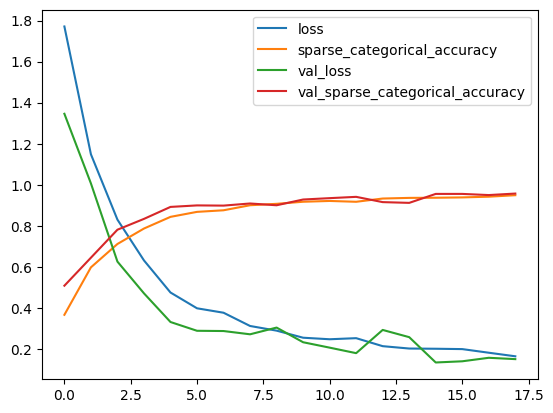

In [ ]:
loss_df.plot();

In [ ]:
model.evaluate(test_data)

94/94 [==============================] - 7s 78ms/step - loss: 0.1529 - sparse_categorical_accuracy: 0.9587


[0.1529145985841751, 0.9586666822433472]

In [ ]:
# os.makedirs(os.path.join("drive", "MyDrive", "vegetable_classification_models"))

In [ ]:
# model.save(os.path.join("drive", "MyDrive", "vegetable_classification_models","vegetable_classification_model.h5"))

MODEL QUANTIZATION

In [ ]:
model = tf.keras.models.load_model(os.path.join("drive", "MyDrive", "vegetable_classification_models","vegetable_classification_model.h5"))

In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

In [ ]:
# def representative_data_gen():
#   for input_value in tf.data.Dataset.from_tensor_slices(training_data).batch(1).take(100):
#     yield [input_value]

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_data_gen
# # Ensure that if any ops can't be quantized, the converter throws an error
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# # Set the input and output tensors to uint8 (APIs added in r2.3)
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

# tflite_model_quant = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


SAVING TFLITE MODEL

In [ ]:
# import pathlib

# tflite_models_dir = pathlib.Path(os.path.join("drive", "MyDrive", "vegetable_classification_models"))
# tflite_models_dir.mkdir(exist_ok=True, parents=True)
# tflite_model_file = tflite_models_dir/"vegetable_classification_model.tflite"
# tflite_model_file.write_bytes(tflite_model)

185583188

TFLITE MODEL INFERENCE

In [11]:
import tensorflow.lite as lite
import os
from matplotlib.pyplot import imread
from numpy import expand_dims

In [ ]:
# def predict(tflite_file, test_image):
#   interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
#   interpreter.allocate_tensors()

#   input_details = interpreter.get_input_details()[0]
#   output_details = interpreter.get_output_details()[0]

#   test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
#   interpreter.set_tensor(input_details["index"], test_image)
#   interpreter.invoke()
#   output = interpreter.get_tensor(output_details["index"])[0]

#   predictions = output.argmax()
#   # predictions = output

#   return predictions

In [ ]:
def predict(tflite_file, test_image):
  interpreter = lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  test_image = expand_dims(test_image, axis=0).astype(input_details["dtype"])
  interpreter.set_tensor(input_details["index"], test_image)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details["index"])[0]

  predictions = output.argmax()
  # predictions = output

  return predictions

In [ ]:
CLASS_INDICES = {'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}
DATA_PATH = os.path.join('Vegetable Images')
TEST_PATH = os.path.join(DATA_PATH, "test")

In [ ]:
test_image = imread(os.path.join(TEST_PATH, "Carrot", "1033.jpg"))/255.
tflite_model_file = os.path.join("drive", "MyDrive", "vegetable_classification_models", "vegetable_classification_model.tflite")
[*CLASS_INDICES.keys()][predict(tflite_model_file, test_image)]

'Carrot'